In this notebook, some text feature is introduced. And i will give some insight and product method in shopee compte. If you find usefule, please give upvote, thx.

- Title edit distance
- TFIDF
- BM25
- Word2vec
- Bert

In [1]:
DATA_PATH = '../input/shopee-product-matching/'

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2, matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import gc

# f1 score metric
def getMetric(col):
    def f1score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        return 2*n / (len(row.target)+len(row[col]))
    return f1score

train = pd.read_csv(DATA_PATH + 'train.csv')
train['image'] = DATA_PATH + 'train_images/' + train['image']
tmp = train.groupby('label_group').posting_id.agg('unique').to_dict()
train['target'] = train.label_group.map(tmp)

In [2]:
train = train.sort_values(by='label_group')
train['title'] = train['title'].str.lower()
train.head()

posting_id                                              image  \
3874   train_1646767365  ../input/shopee-product-matching/train_images/...   
31859  train_1528423085  ../input/shopee-product-matching/train_images/...   
6738    train_398181303  ../input/shopee-product-matching/train_images/...   
7613   train_2865605743  ../input/shopee-product-matching/train_images/...   
12367  train_1382500866  ../input/shopee-product-matching/train_images/...   

            image_phash                                              title  \
3874   e925873ed09cd08f  sarung celana wadimor original 100% dewasa dan...   
31859  ea97861c926a71e3  warna random acak sarung celana wadimor murah ...   
6738   e9b5833e929e909c    sarung celana wadimor dewasa hitam polos sarcel   
7613   bfc3cc1cc636c14c  wall sticker / wallsticker -  submarine measur...   
12367  838436c07dff19e4  reliza wall sticker pengukur tinggi badan jera...   

       label_group                                             target  
3874        258047  [train_1646767365, train_398181303, train_1528...  
31859       258047  [train_1646767365, train_398181303, train_1528...  
6738        258047  [train_1646767365, train_398181303, train_1528...  
7613        297977               [train_2865605743, train_1382500866]  
12367       297977               [train_2865605743, train_1382500866]

# Title Edit Distance

Edit distance is a way of quantifying how dissimilar two strings (e.g., words) are to one another by counting the minimum number of operations required to transform one string into the other.

字符编辑距离可用衡量标题的距离。在这里可以直接计算两个商品的标题共同包含了多少个单词。

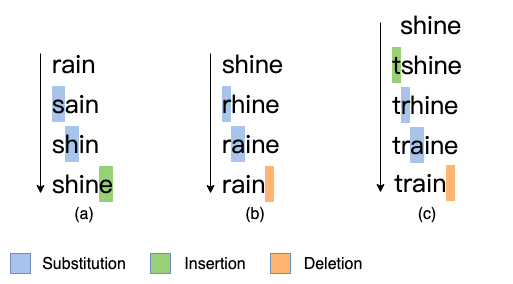

https://stackoverflow.com/questions/2460177/edit-distance-in-python

In shopee, you can find product in same group may have common word, so we can count the intersect words count.

In [3]:
def title_share_distance(s1, s2):
    s1_word = set(s1.split(' '))
    s2_word = set(s2.split(' '))
    return 1 - len((s1_word.intersection(s2_word))) / len(s1_word.union(s2_word))

In [4]:
# same group
title_share_distance(train['title'].iloc[0], train['title'].iloc[1])

0.8

In [5]:
# same group
title_share_distance(train['title'].iloc[0], train['title'].iloc[2])

0.5

In [6]:
# different group
title_share_distance(train['title'].iloc[0], train['title'].iloc[1000])

0.9565217391304348

In [7]:
# different group
title_share_distance(train['title'].iloc[0], train['title'].iloc[2000])

1.0

# TFIDF

The tf–idf is the product of two statistics, term frequency and inverse document frequency. There are various ways for determining the exact values of both statistics. 

TFIDF contains two parts: TF(term frequency) and IDF(inverse document frequency).
* TF is the word count in each sentence.
* IDF is the importance of each word.

TFIDF是非常有效的，TF计算了词频，IDF计算了词的重要性。

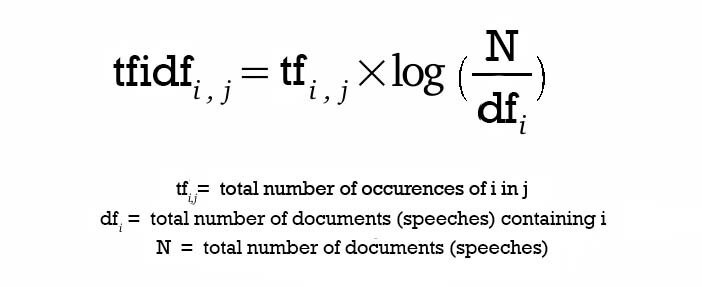

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


TFIDF can count single word or two-word/three-word together, in shopee compte single word is good and memory effectient.

TFIDF 可以计算1-gram，2-gram，但在shopee题目中1-gram足够。

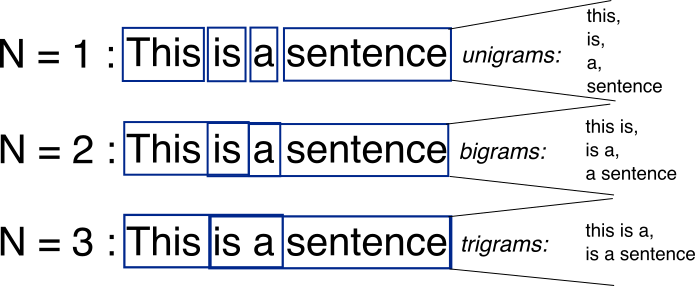

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

print(X.shape)

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
(4, 9)


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

print(X.shape)

['and', 'and this', 'document', 'document is', 'first', 'first document', 'is', 'is the', 'is this', 'one', 'second', 'second document', 'the', 'the first', 'the second', 'the third', 'third', 'third one', 'this', 'this document', 'this is', 'this the']
(4, 22)


In [10]:
model = TfidfVectorizer(stop_words=None, binary=True, max_features=55000)
text_embeddings = model.fit_transform(train.title).toarray()
print('text embeddings shape',text_embeddings.shape)

text embeddings shape (34250, 25069)


In [11]:
import torch
text_embeddings = torch.from_numpy(text_embeddings)
text_embeddings = text_embeddings.cuda()

In [12]:
preds = []
CHUNK = 1024*2

print('Finding similar titles...')
CTS = len(train)//CHUNK
if len(train)%CHUNK!=0: CTS += 1
text_ids = None
    
for j in range( CTS ):
    
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(train))
    print('chunk',a,'to',b)
    
    cts = torch.matmul(text_embeddings, text_embeddings[a:b].T).T
    cts = cts.data.cpu().numpy()
    for k in range(b-a):
        IDX = np.where(cts[k,]>0.6)[0]
        o = train.iloc[IDX].posting_id.values
        preds.append(o)
        
    del cts
    torch.cuda.empty_cache()

Finding similar titles...
chunk 0 to 2048
chunk 2048 to 4096
chunk 4096 to 6144
chunk 6144 to 8192
chunk 8192 to 10240
chunk 10240 to 12288
chunk 12288 to 14336
chunk 14336 to 16384
chunk 16384 to 18432
chunk 18432 to 20480
chunk 20480 to 22528
chunk 22528 to 24576
chunk 24576 to 26624
chunk 26624 to 28672
chunk 28672 to 30720
chunk 30720 to 32768
chunk 32768 to 34250


In [13]:
del text_embeddings
torch.cuda.empty_cache()

train['oof_text'] = preds

we can also omit the top fraq word.

In [14]:
from collections import Counter
word_counter = Counter(' '.join(train['title'].values).split(' '))
most_occur = pd.DataFrame({'word': word_counter.keys(), 'count': word_counter.values()})
most_occur = most_occur[most_occur['word'].apply(len) > 1]

most_occur = most_occur.sort_values(by='count', ascending=False)
most_occur.head(10)

word  count
7        anak   1916
111    wanita   1820
3    original   1681
14      murah   1363
149       tas   1192
6         dan   1157
378      pria   1122
946    masker   1111
110     untuk   1068
72       bayi   1061

# BM25

Okapi BM25 (BM is an abbreviation of best matching) is a ranking function used by search engines to estimate the relevance of documents to a given search query.

BM25 improves upon TF*IDF. BM25 stands for “Best Match 25”. Released in 1994, it’s the 25th iteration of tweaking the relevance computation. BM25 has its roots in probabilistic information retrieval. 

BM25是对TFIDF的改进，在精度上有一定提高。

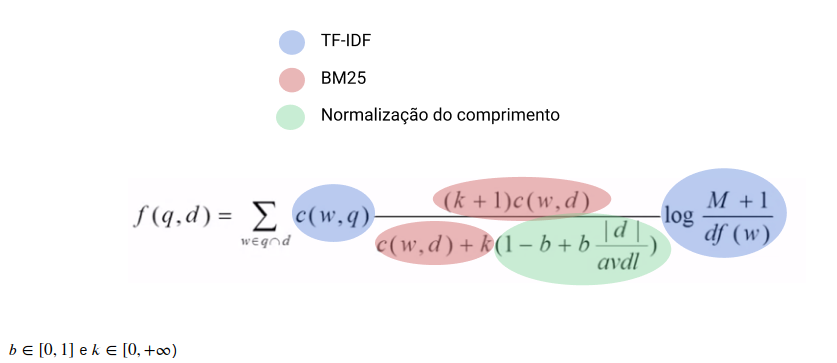

https://github.com/dorianbrown/rank_bm25
https://www.kaggle.com/ideanlabib/bm25-search-query-similarity-ranking/
https://gist.github.com/koreyou/f3a8a0470d32aa56b32f198f49a9f2b8

In [15]:
!pip install rank_bm25

In [16]:
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
train_title_token = train['title'].apply(lambda x: word_tokenize(x))

In [17]:
bm25 = BM25Okapi(train_title_token)

In [18]:
ids = bm25.get_scores(train_title_token.iloc[200])
idx = np.where(ids>50)[0]
print(ids[idx])
train.iloc[idx]

[67.95479795 52.91981453 51.12520596]


posting_id                                              image  \
29449  train_2181332714  ../input/shopee-product-matching/train_images/...   
25246  train_4129791793  ../input/shopee-product-matching/train_images/...   
30719  train_3493652138  ../input/shopee-product-matching/train_images/...   

            image_phash                                  title  label_group  \
29449  bb39c4c6c6399a91  bedak salicyl 60gr | bedak salicyl kf     25802082   
25246  bb39c4c6c6399a91                     bedak salicyl 60gr     25802082   
30719  b987860f3b78c664                  salicyl bedak kf 60ml     25802082   

                                                  target  \
29449  [train_4129791793, train_1553039102, train_218...   
25246  [train_4129791793, train_1553039102, train_218...   
30719  [train_4129791793, train_1553039102, train_218...   

                                                oof_text  
29449  [train_2181332714, train_4129791793, train_349...  
25246  [train_2181332714, train_4129791793, train_349...  
30719  [train_2181332714, train_4129791793, train_349...

In [19]:
ids = bm25.get_scores(train_title_token.iloc[1000])
idx = np.where(ids>50)[0]
print(ids[idx])
train.iloc[idx]

[61.27281093 50.35020784 50.35020784 74.60902782 50.35020784 75.22831507
 90.87201512 78.94702083 97.28090579]


posting_id                                              image  \
24504  train_1165058967  ../input/shopee-product-matching/train_images/...   
3165   train_2823824337  ../input/shopee-product-matching/train_images/...   
8551   train_1831498823  ../input/shopee-product-matching/train_images/...   
2207   train_3597470302  ../input/shopee-product-matching/train_images/...   
13444  train_2857221499  ../input/shopee-product-matching/train_images/...   
115     train_404207615  ../input/shopee-product-matching/train_images/...   
7354   train_3960172945  ../input/shopee-product-matching/train_images/...   
28958   train_530505223  ../input/shopee-product-matching/train_images/...   
5806   train_3990088467  ../input/shopee-product-matching/train_images/...   

            image_phash                                              title  \
24504  e1729e67c63460cd                   natur hair tonic aloe vera 90 ml   
3165   e1729e67c63460d9                    natur hair tonic gingseng 90 ml   
8551   e8ce87079771d170                    natur hair tonic gingseng 90 ml   
2207   eec8c0cdcf829596                    natur hair tonic aloe vera 90ml   
13444  e6cecc64c9319993                    natur hair tonic gingseng 90 ml   
115    ae2ed1d1d1d12ad8        natur hair tonic ginseng dan aloe vera 90ml   
7354   d8c327356e1c1f38  bpom - natur hair tonic 90ml / natur hair toni...   
28958  9de1c616323b694b  [bpom] natur hair tonic 90ml / hair tonic gins...   
5806   811d7e697a6619e4  original natur hair tonic 90ml bpom / hair ton...   

       label_group                                             target  \
24504    122550860  [train_404207615, train_3597470302, train_2823...   
3165     122550860  [train_404207615, train_3597470302, train_2823...   
8551     122550860  [train_404207615, train_3597470302, train_2823...   
2207     122550860  [train_404207615, train_3597470302, train_2823...   
13444    122550860  [train_404207615, train_3597470302, train_2823...   
115      122550860  [train_404207615, train_3597470302, train_2823...   
7354     122550860  [train_404207615, train_3597470302, train_2823...   
28958    122550860  [train_404207615, train_3597470302, train_2823...   
5806     122550860  [train_404207615, train_3597470302, train_2823...   

                                                oof_text  
24504  [train_1165058967, train_2823824337, train_183...  
3165   [train_1165058967, train_2823824337, train_183...  
8551   [train_1165058967, train_2823824337, train_183...  
2207   [train_1165058967, train_3597470302, train_404...  
13444  [train_1165058967, train_2823824337, train_183...  
115    [train_1165058967, train_3597470302, train_404...  
7354   [train_3597470302, train_404207615, train_3960...  
28958  [train_3597470302, train_404207615, train_3960...  
5806   [train_3597470302, train_404207615, train_3960...

# Word2Vec

Word embedding capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. Word2vec represents each distinct word with a particular list of numbers called a vector. The vectors are chosen carefully such that a simple mathematical function (the cosine similarity between the vectors) indicates the level of semantic similarity between the words represented by those vectors.

词向量可以将单词映射到向量空间，相似的相似映射后距离相近，我们也可以借助预训练好词向量来完成title 相似度计算。

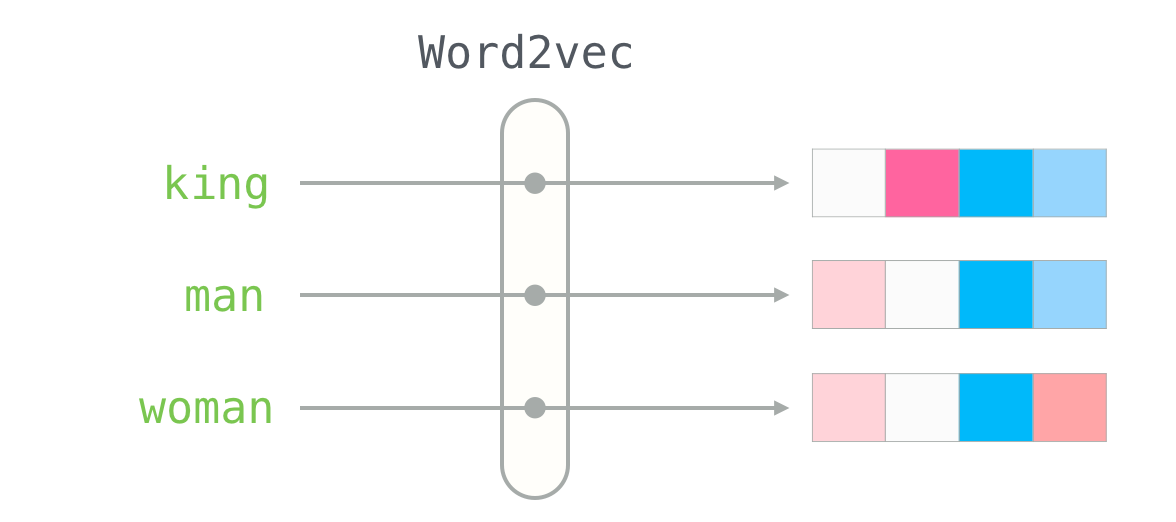

* https://en.wikipedia.org/wiki/Word2vec
* https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa

In [20]:
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

vectors = KeyedVectors.load_word2vec_format("../input/glove2word2vec/glove_w2v.txt") # import the data file

In [21]:
text_embeddings = []
for title in tqdm_notebook(train_title_token[:]):
    title_feat = []
    for word in title:
        if word in vectors:
            title_feat.append(vectors[word])
    
    if len(title_feat) == 0:
        title_feat = np.random.rand(200)
    else:
        # max-pooling
        # mean-pooling
        # IDF
        # SIF
        title_feat = np.vstack(title_feat).max(0)
    text_embeddings.append(title_feat)
    # break

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/34250 [00:00<?, ?it/s]

In [22]:
from sklearn.preprocessing import normalize

# l2 norm to kill all the sim in 0-1
text_embeddings = np.vstack(text_embeddings)
text_embeddings = normalize(text_embeddings)

import torch
text_embeddings = torch.from_numpy(text_embeddings)
text_embeddings = text_embeddings.cuda()


In [23]:
preds = []
CHUNK = 1024*4


print('Finding similar images...')
CTS = len(text_embeddings)//CHUNK
if len(text_embeddings)%CHUNK!=0: CTS += 1
for j in range( CTS ):
    
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(train))
    print('chunk',a,'to',b)
    
    cts = torch.matmul(text_embeddings, text_embeddings[a:b].T).T
    cts = cts.data.cpu().numpy()
    for k in range(b-a):
        IDX = np.where(cts[k,]>0.93)[0]
        o = train.iloc[IDX].posting_id.values
        preds.append(o)
        
    del cts
    torch.cuda.empty_cache()

Finding similar images...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


In [24]:
train['oof_w2v'] = preds

## Train Your Own Word2Vec

we can train word2vec on shopee dataset.

* https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
* https://radimrehurek.com/gensim/models/word2vec.html

In [25]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [26]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [27]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

model = Word2Vec(sentences=train_title_token, vector_size=200, window=5, min_count=1, workers=4)
model.save("word2vec.model")

# Bert

Bidirectional Encoder Representations from Transformers (BERT) is a Transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google.

we can finetune bert on Next Sentense Prediction (NSP) task, try to match two product by title.
* first construct title pair (match or not match)
* load bert model
* define loss and train

Bert模型非常强大，且可以用于文本匹配任务。如果使用文本匹配的思路，则需要构建匹配训练集，然后定义模型并训练。

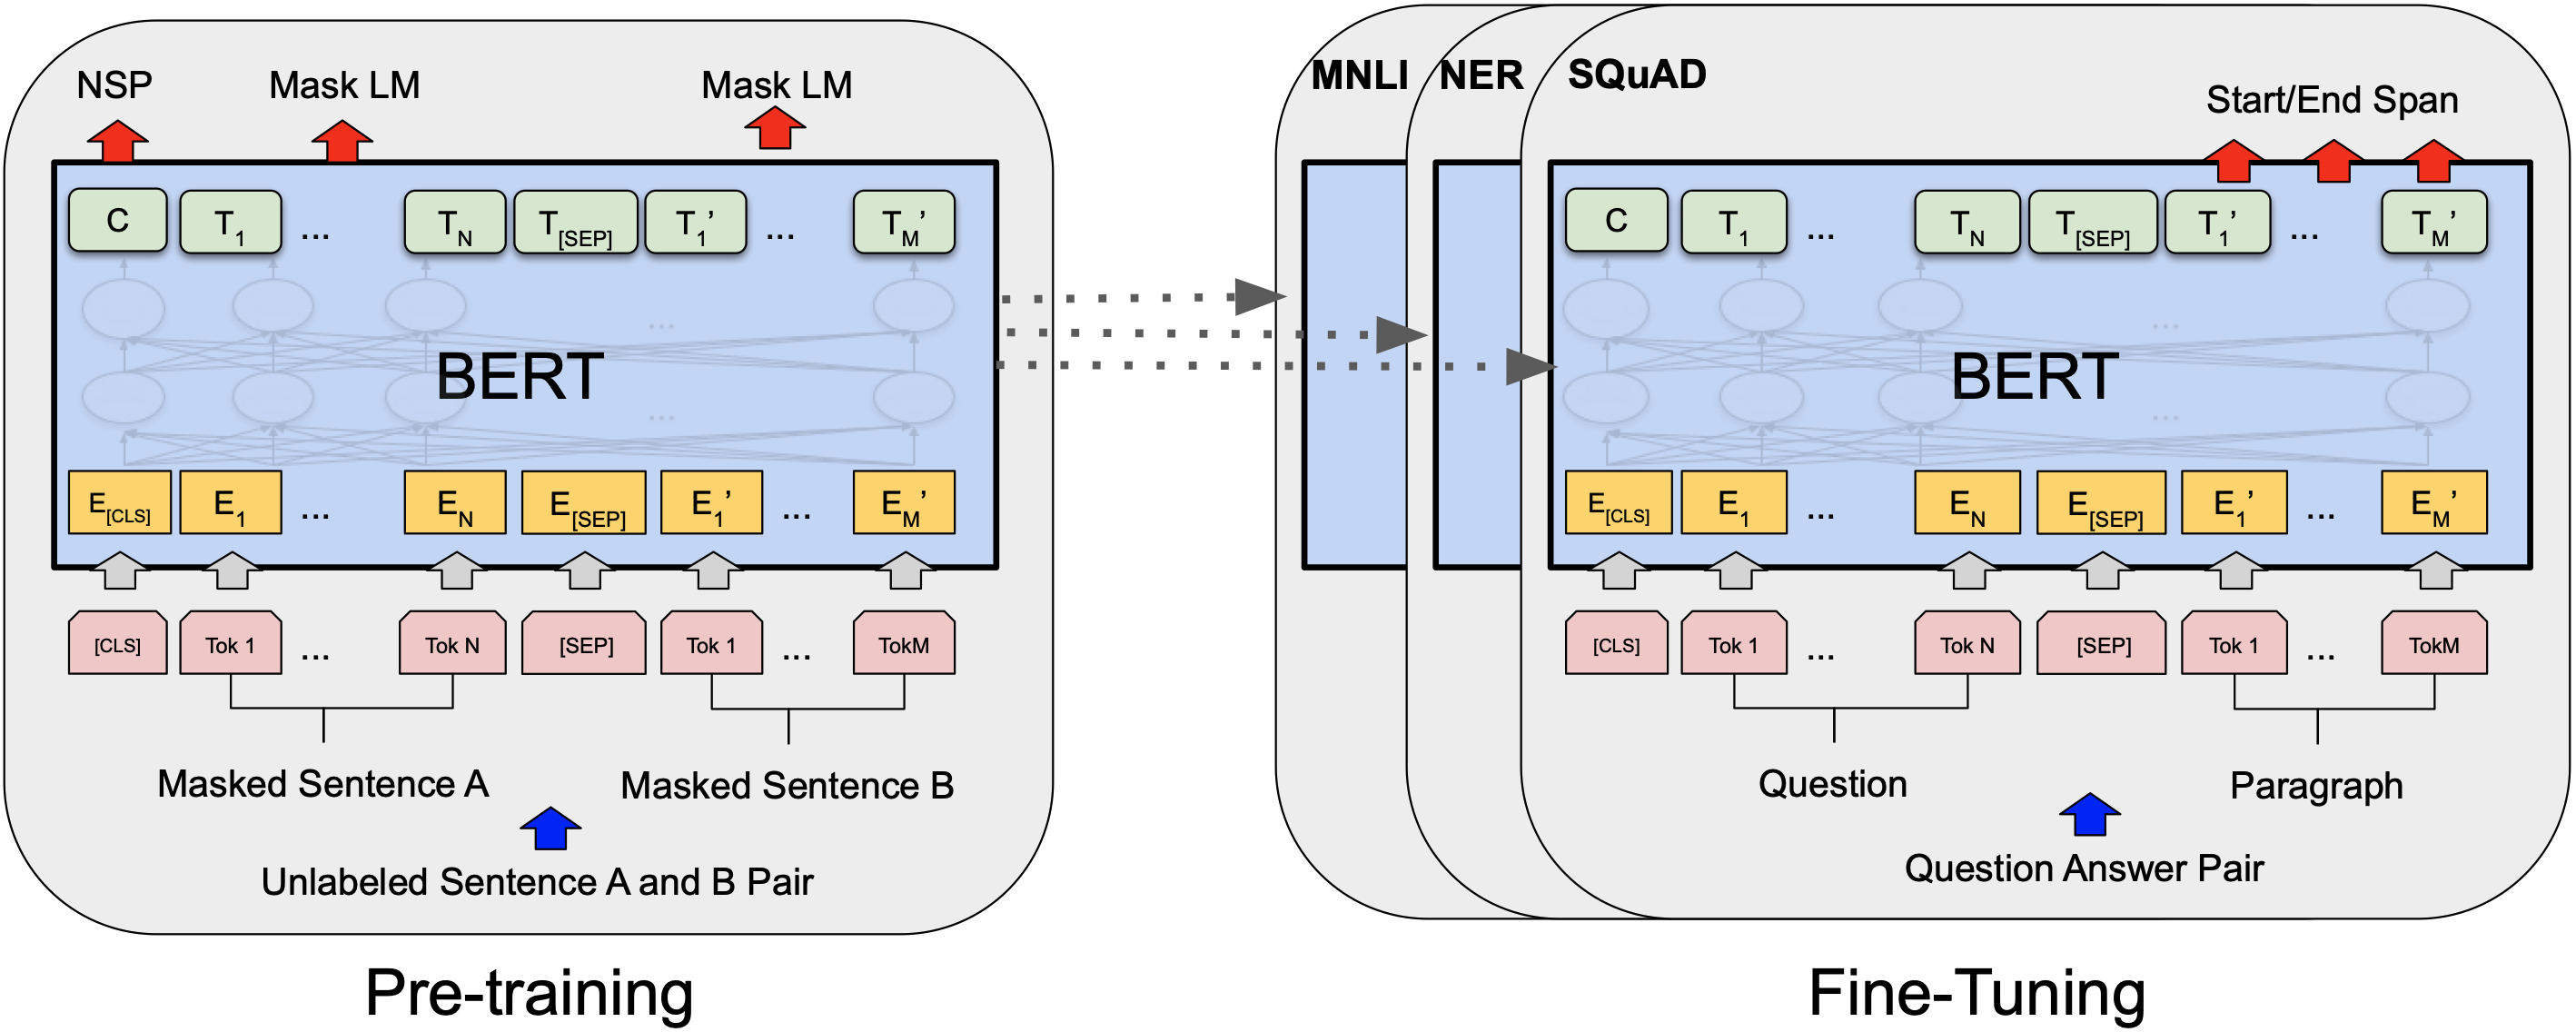

https://en.wikipedia.org/wiki/BERT_(language_model)

In [28]:
def combine_for_oof(row):
    x = np.concatenate([row.oof_text,row.oof_w2v])
    return np.unique(x)

# merge product proposal by tfidf and word2vec, we have positive and negative example.
# if two product in same group they are positive label.
train['oof'] = train.apply(combine_for_oof,axis=1)

In [29]:
train = train.set_index('posting_id')

In [30]:
title_pair = []
for row in tqdm_notebook(train.iterrows()):
    for pair in row[1].oof:
        # not match self
        if pair == row[0]:
            continue
    
        if pair in row[1].target:
            lbl = 1
        else:
            lbl = 0

        title_pair.append(
            [row[1].title, train.loc[pair]['title'], lbl]
        )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0it [00:00, ?it/s]

In [31]:
title_pair = pd.DataFrame(title_pair, columns=['s1', 's2', 'label'])
title_pair = title_pair.sample(frac=1)
title_pair.head(5)

s1  \
395293  [cod / qipin] 30pcs stiker tato sementara moti...   
373638           celana futsal gym sport / training pants   
390393        implora lip tint - implora cheek & lip tint   
141857            waistbag as - tas selempang pria wanita   
404065                   mukena tazbiya mixed plain black   

                                                       s2  label  
395293  falsh sale cod dnm eyebrow pencil pensil alis ...      0  
373638  celana pendek pria sport running / training bo...      1  
390393                     implora cheek & lip tint 5.5gr      1  
141857        morymony tas anabele - tas selempang wanita      0  
404065  mukena tazkia polos renda / plain black origin...      0

In [32]:
train_pair = title_pair.iloc[:5000]
val_pair = title_pair.iloc[5000:6000]

In [33]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-cased", model_max_length=128)
sequence_a = "HuggingFace is based in NYC"
sequence_b = "Where is HuggingFace based?"
encoded_dict = tokenizer(sequence_a, sequence_a)
encoded_dict

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'input_ids': [101, 20164, 10932, 2271, 7954, 1110, 1359, 1107, 17520, 102, 20164, 10932, 2271, 7954, 1110, 1359, 1107, 17520, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random
import re

class ShopeeTextDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __getitem__(self, idx):
        item = tokenizer(self.df.iloc[idx]['s1'], self.df.iloc[idx]['s2'], 
                         truncation=True, padding='max_length',  max_length=128)
        item = {key: torch.tensor(val) for key, val in item.items()}
        item['labels'] = torch.tensor(self.df.iloc[idx]['label'])
        return item
    
    def __len__(self):
        return self.df.shape[0]

In [35]:
from transformers import BertForSequenceClassification, AdamW
model = BertForSequenceClassification.from_pretrained('bert-base-cased')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [36]:
optim = AdamW(model.parameters(), lr=2e-5)
train_dataset = ShopeeTextDataset(train_pair)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ShopeeTextDataset(val_pair)
val_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [37]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train():
    model.train()
    total_train_loss = 0
    iter_num = 0
    total_iter = len(train_loader)
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optim.step()

        iter_num += 1
        if(iter_num % 100==0):
            print("epoth: %d, iter_num: %d, loss: %.4f, %.2f%%" % (epoch, iter_num, loss.item(), iter_num/total_iter*100))
        
    print("Epoch: %d, Average training loss: %.4f"%(epoch, total_train_loss/len(train_loader)))
    
def validation():
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    for batch in tqdm_notebook(val_loader):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs[0]
        logits = outputs[1]

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    print("Accuracy: %.4f" % (avg_val_accuracy))
    print("Average testing loss: %.4f"%(total_eval_loss/len(val_loader)))
    print("-------------------------------")

In [38]:
for epoch in range(3):
    print("------------Epoch: %d ----------------" % epoch)
    train()
    validation()

------------Epoch: 0 ----------------
epoth: 0, iter_num: 100, loss: 0.1468, 31.95%
epoth: 0, iter_num: 200, loss: 0.4734, 63.90%
epoth: 0, iter_num: 300, loss: 0.0519, 95.85%
Epoch: 0, Average training loss: 0.2817


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy: 0.8902
Average testing loss: 0.2516
-------------------------------
------------Epoch: 1 ----------------
epoth: 1, iter_num: 100, loss: 0.4333, 31.95%
epoth: 1, iter_num: 200, loss: 0.1381, 63.90%
epoth: 1, iter_num: 300, loss: 0.2078, 95.85%
Epoch: 1, Average training loss: 0.1823


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy: 0.9613
Average testing loss: 0.1155
-------------------------------
------------Epoch: 2 ----------------
epoth: 2, iter_num: 100, loss: 0.0136, 31.95%
epoth: 2, iter_num: 200, loss: 0.0157, 63.90%
epoth: 2, iter_num: 300, loss: 0.0205, 95.85%
Epoch: 2, Average training loss: 0.1461


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy: 0.9605
Average testing loss: 0.1010
-------------------------------


# Conclusion & Advice

1. BM25 is more effective than TFIDF, but it's a litter slow.
2. use title embedding in word2vec to find similar product maybe not a good idea.
3. we can use bert to rank the product:
    * first search product by cnn feature
    * then match the product by bert title model.
4. try sentence-bet.